# Deliverables



1. A report (in the form of a presentation, both verbal and through a slides)


2. A github repository containing your jupyter notebook that walks through the pipeline along with the .py files necessary to reproduce your model.



In [255]:
import wrangle
import pandas as pd
import numpy as np
import evaluate
import explore
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats
import split_scale
import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.metrics import median_absolute_error, r2_score
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
from pygam import LinearGAM, s, f, te
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from scipy import sparse
import models


In [256]:
#use wrangle.py to import data from mySQL
df =wrangle.get_data_from_sql()

In [257]:
# check DF head
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
0,2.000,3.000,1458.000,6037.000,8284.000,1.000,97318.000,1970.000,34686163.000,-118113100.000,136104.000,2319.900,2017-06-23
1,1.000,2.000,1421.000,6037.000,6707.000,nan,96018.000,1911.000,33999877.000,-118291863.000,35606.000,543.690,2017-06-30


In [258]:
# check DF tail
df.tail(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
14988,3.000,5.000,2655.000,6059.000,6000.000,nan,97065.000,1994.000,33836898.000,-117801369.000,746963.000,8065.500,2017-06-30
14989,3.000,4.000,2305.000,6037.000,5742.000,nan,96129.000,1949.000,33952368.000,-118441155.000,579047.000,6996.210,2017-06-30


In [259]:
# there are null values in lot_size, pool, zip_code, year_built and tax-value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 13 columns):
bathrooms           14990 non-null float64
bedrooms            14990 non-null float64
square_feet         14990 non-null float64
fips                14990 non-null float64
lot_size            14893 non-null float64
pool                3287 non-null float64
zip_code            14982 non-null float64
year_built          14974 non-null float64
latitude            14990 non-null float64
longitude           14990 non-null float64
assessed_value      14990 non-null float64
tax_value           14989 non-null float64
transaction_date    14990 non-null object
dtypes: float64(12), object(1)
memory usage: 1.5+ MB


In [260]:
#wrangle data to remove NANs
df = wrangle.wrangle_zillow()

In [261]:
#create a new column tax-rate
df['tax_rate'] = df.tax_value/df.assessed_value

In [262]:
#https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
#source for county fips code. Read codes in a data DataFrame named fips_codes
#fips_codes = pd.read_clipboard()

In [263]:
fips_code = pd.DataFrame({
    'fips': [6037, 6059, 6111],
    'County':['Los Angles', 'Orange', 'Ventura']
})
fips_code.head()

,fips,County
0,6037,Los Angles
1,6059,Orange
2,6111,Ventura


In [264]:
#merge df and fips_codes 
df = pd.merge(df, fips_code, left_on='fips', right_on='fips', how='left')

In [265]:
# add some logrithmic variables
df['log2sf'] = np.log2(df['square_feet'])
df['log2lot_size'] = np.log2(df['lot_size'])
df['log2value'] = np.log2(df['assessed_value'])
df['age'] = 2000-df.year_built

In [266]:
#add median home value to each row for corresponding zip_code
zip1 = df.zip_code
list1 = list(zip1)
(df[df.zip_code == list1[3]]).assessed_value.median()

def median_v(df, l):
    list2 = []
    for i in range(0, len(l)):
        median1 = (df[df.zip_code == l[i]]).assessed_value.median()
        list2.append(median1)
    return list2

list3 = median_v(df, list1)
list3 = pd.DataFrame(list3, columns=['zip_median'])
df = pd.concat([df, list3], axis=1)
df['log2_zip_median'] = np.log2(df['zip_median'])

In [267]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,...,tax_value,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age,zip_median,log2_zip_median
0,2.000,3.000,1458.000,6037,8284,1,97318,1970,34686163.000,-118113100.000,...,2319.900,2017-06-23,0.017,Los Angles,10.510,13.016,17.054,30,144172.000,17.137
1,1.000,2.000,1421.000,6037,6707,0,96018,1911,33999877.000,-118291863.000,...,543.690,2017-06-30,0.015,Los Angles,10.473,12.711,15.120,89,162337.000,17.309


In [273]:
# save data in a .csv file
#df.to_csv('zillow_cleaned1.csv')

In [268]:
#split the data into train and test
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [269]:
#create a subset of df with continuous variables to create pairplot
train_plot = train[['bathrooms', 'bedrooms', 'square_feet', 'zip_median', 'assessed_value']]

In [16]:
#df.groupby(['zip_code']).agg(['mean', 'count'])

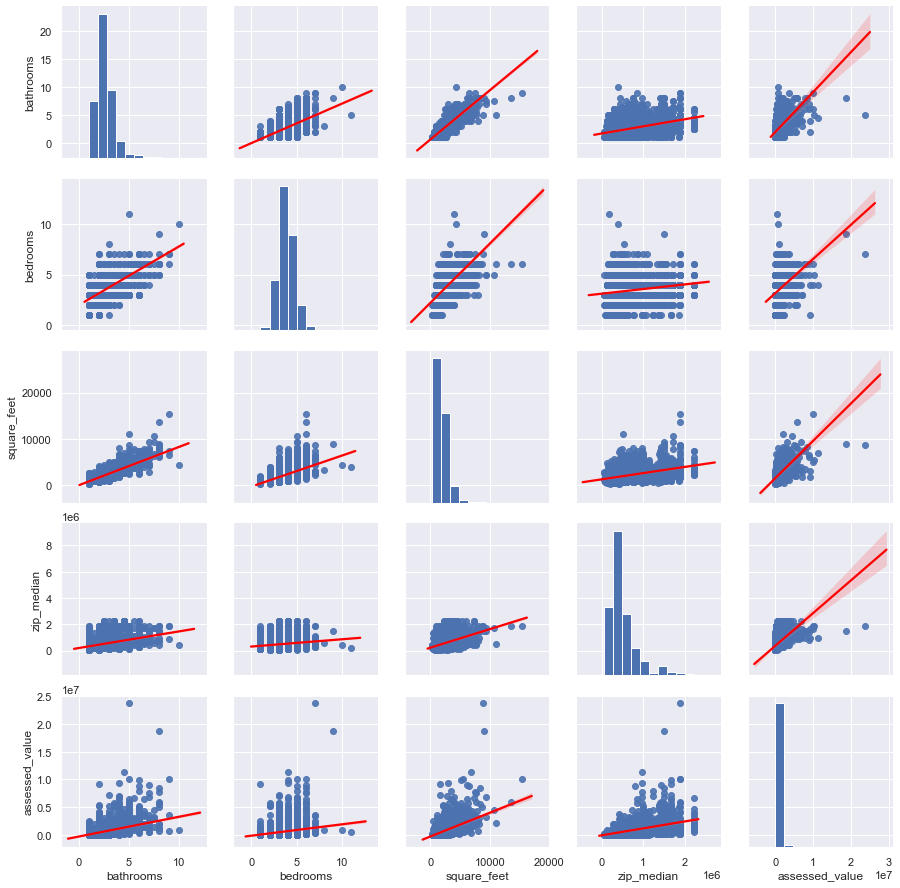

In [17]:
explore.plot_variable_pairs(train_plot)

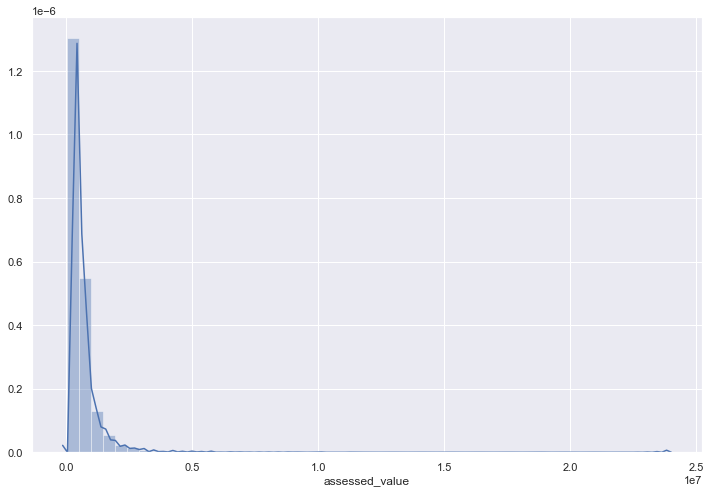

In [270]:
# plot showing distribution of home values. This looks like right skewed distribution
sns.distplot(train.assessed_value)

In [271]:
cm = train_plot.corr()
cm

,bathrooms,bedrooms,square_feet,zip_median,assessed_value
bathrooms,1.000,0.642,0.855,0.402,0.505
bedrooms,0.642,1.000,0.628,0.160,0.264
square_feet,0.855,0.628,1.000,0.435,0.589
zip_median,0.402,0.160,0.435,1.000,0.558
assessed_value,0.505,0.264,0.589,0.558,1.000


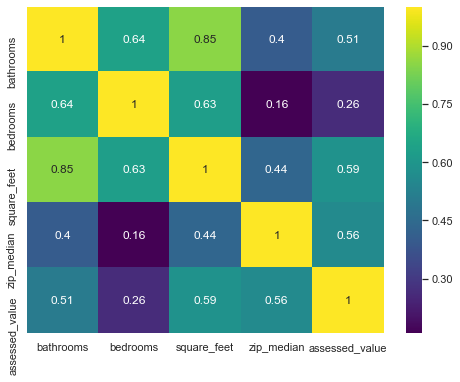

In [272]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

# $H_0$: there is no relationship between home values and number of bedrooms, bathrooms and square_feet
# $H_a$: There is a relationship between home values and number of bedrooms, bathrooms and square_feet

In [277]:
#Lets take a look at simple model based on bathoom, bedroom and squarefeet and compare if against the baseline(median home value)
X_train = train[['bedrooms', 'bathrooms', 'square_feet']]
y_train = train[['assessed_value']]
X_test = test[['bedrooms', 'bathrooms', 'square_feet']]
y_test = test[['assessed_value']]

In [278]:
# make a dataframe 'predictions' with actual home values
predictions = pd.DataFrame({
    'actual': y_train.assessed_value
})
predictions.head(2)

,actual
11938,268557.000
790,95849.000


In [279]:
predictions['median_bl'] =  train['assessed_value'].median()
predictions['mean_bl'] =  train['assessed_value'].mean()

In [280]:
predictions.head(2)

,actual,median_bl,mean_bl
11938,268557.000,389610.000,543785.239
790,95849.000,389610.000,543785.239


In [281]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('assessed_value ~ bedrooms + bathrooms + square_feet', data = train).fit()

# compute predictions and add to original dataframe
predictions['ols'] = ols_model.predict(X_train)

In [282]:
predictions.head(2)

,actual,median_bl,mean_bl,ols
11938,268557.000,389610.000,543785.239,718051.869
790,95849.000,389610.000,543785.239,316295.362


In [283]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: median_absolute_error(predictions.actual, col))

actual           0.000
median_bl   209842.000
mean_bl     276775.239
ols         193941.156
dtype: float64

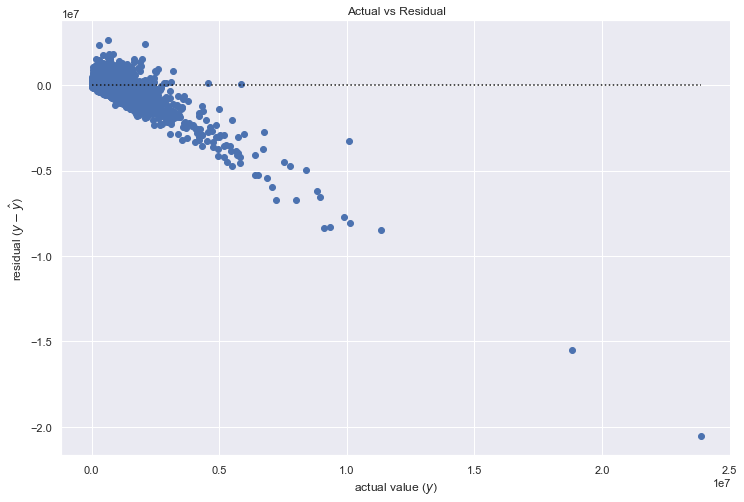

In [285]:
#Lets look at residuals
evaluate.plot_residuals(predictions.actual, predictions.ols, predictions)



# Looks like there is a clear trend. The model seems to be doing well at lower home values, but diverges significantly at higher price levels. 

In [286]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         assessed_value   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     2007.
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:47:58   Log-Likelihood:            -1.5278e+05
No. Observations:               10411   AIC:                         3.056e+05
Df Residuals:                   10407   BIC:                         3.056e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5989.8197    2.1e+04     -0.285      0.776   -4.72e+04    3.52e+04
bedrooms    -1.465e+05   8045.351    -18.211      0.000   -1.62e+05   -1.31e+05
bathrooms    5.748e+04    1.1e+04      5.220      0.000    3.59e+04    7.91e+04
square_feet   465.3172     11.199     41.549      0.000     443.364     487.270
==============================================================================
Omnibus:                    16670.764   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26785887.300
Skew:                          10.040   Prob(JB):                         0.00
Kurtosis:                     250.679   Cond. No.                     8.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Since my p-value is <0.05, I can reject my null hypothesis.
# This means that there is statistically significant relationship between home prices and  independent variables used above.

-------------------------------

# Lets apply this model on test data and see how it performs

In [287]:
y_test['y_ols'] = ols_model.predict(X_test)

In [288]:
y_test.apply(lambda col: median_absolute_error(y_test.assessed_value, col))

assessed_value        0.000
y_ols            192265.741
dtype: float64

# The Median Absolute Error for test data is comparable to train data which means that model is not overfitted

-----------------------------------------------------

(8.0, 26.0)

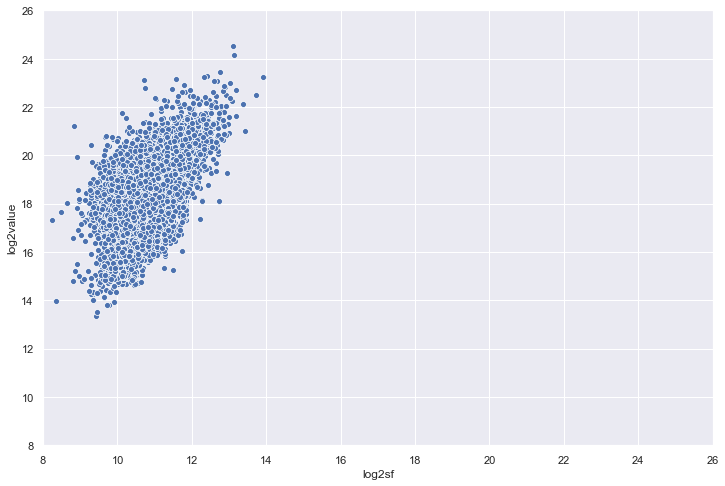

In [289]:
fig, ax = plt.subplots()
sns.scatterplot(x='log2sf', y = 'log2value', data=train, ax = ax)
ax.set_xlim(8,26)
ax.set_ylim(8,26)

(8.0, 26.0)

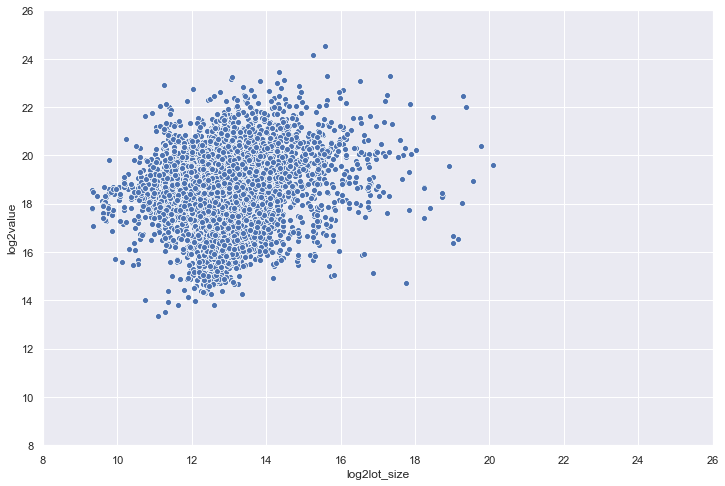

In [290]:
fig, ax = plt.subplots()
sns.scatterplot(x='log2lot_size', y = 'log2value', data=train)
ax.set_xlim(8,26)
ax.set_ylim(8,26)

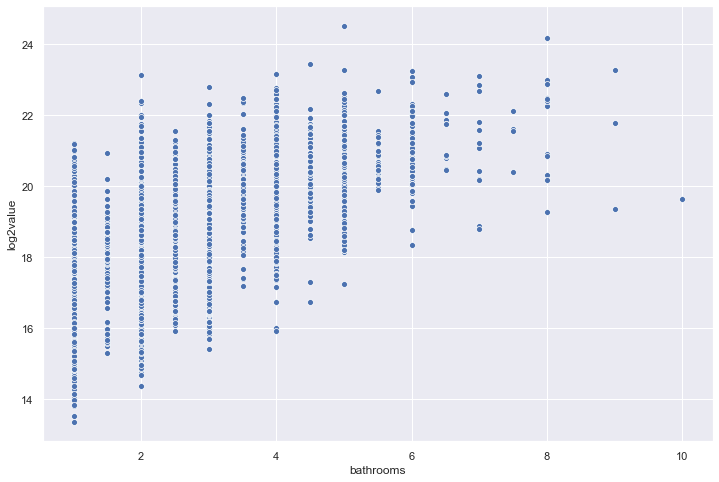

In [291]:
sns.scatterplot(x='bathrooms', y = 'log2value', data=train)

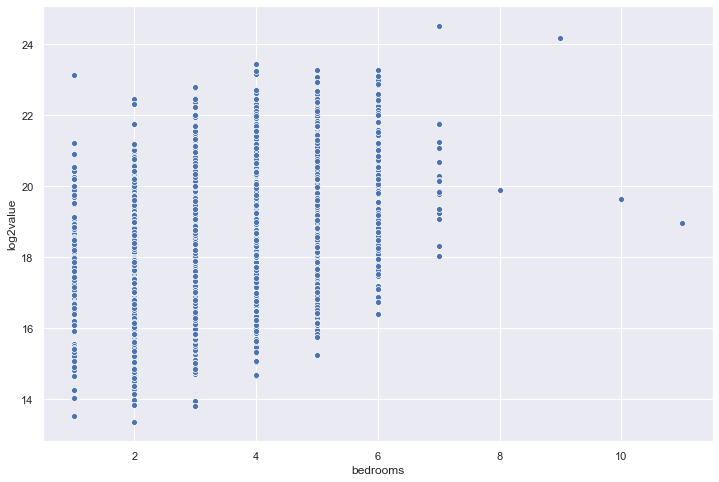

In [292]:
sns.scatterplot(x='bedrooms', y = 'log2value', data=train)

# May be we should try to fit a polynomial function to predict price using log2sf

In [293]:
X_train = train[[ 'log2sf', 'bathrooms']]
y_train = train[['log2value']]
X_test = test[['log2sf', 'bathrooms']]
y_test = test[['log2value']]

In [294]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
poly.get_feature_names()

['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']

In [295]:
X_poly[1]

array([  1.        ,  10.73555602,   2.        , 115.25216314,
        21.47111205,   4.        ])

In [296]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['log_predicted_poly'] = lm_poly.predict(X_poly)

In [297]:
y_train['actual'] = 2**y_train.log2value
y_train['poly_predicted'] = 2**y_train.log_predicted_poly
#y_train['median_bl'] =  train['assessed_value'].median()

In [298]:
y_train.head(2)

,log2value,log_predicted_poly,actual,poly_predicted
11938,18.035,18.723,268557.000,432772.891
790,16.548,18.230,95849.000,307510.340


In [299]:
y_train.apply(lambda col: median_absolute_error(y_train.actual, col))

log2value            389591.428
log_predicted_poly   389592.073
actual                    0.000
poly_predicted       171567.040
dtype: float64

In [300]:
y_train.apply(lambda col: r2_score(y_train.actual, col))

log2value            -0.573
log_predicted_poly   -0.573
actual                1.000
poly_predicted        0.295
dtype: float64

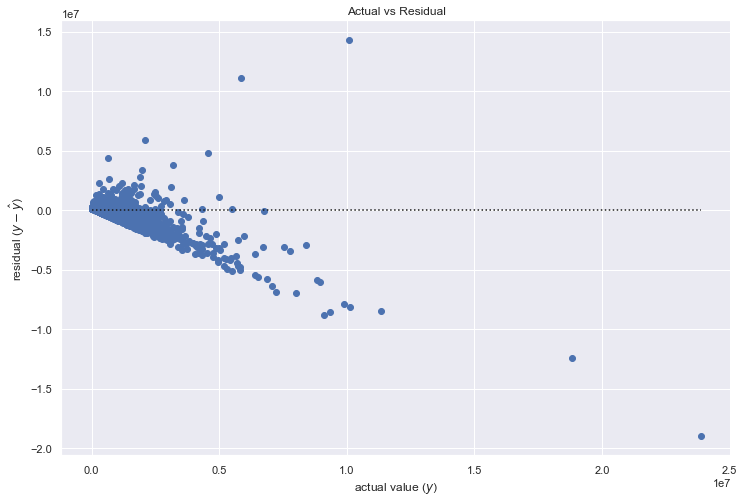

In [301]:
evaluate.plot_residuals(y_train.actual, y_train.poly_predicted, y_train)

# Polynomial Linear  Regression Summary:
# Median Absolute Error: 171,567
# R2 value: 0.295

# Generalized Additive Model (GAM)

In [321]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [322]:
X_train = train[['bathrooms', 'square_feet', 'zip_median']]
y_train = train[['assessed_value']]
X_test = test[[ 'bathrooms', 'square_feet','zip_median']]
y_test = test[['assessed_value']]

In [323]:
#scaler, X_train_scaled, X_test_scaled = split_scale.min_max_scaler(X_train, X_test)

In [324]:
X_test= X_test.to_numpy()
y_test = y_test.to_numpy()

In [325]:
y_train

,assessed_value
11938,268557.000
790,95849.000
3846,324613.000
14846,499860.000
1469,517777.000
...,...
12119,1321024.000
8039,447349.000
14147,665588.000
6936,518732.000


In [326]:
from pygam import LinearGAM, s, f, te
gam = LinearGAM(s(0) +s(1) +s(2))

In [327]:
gam.gridsearch(X_test,y_test)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + s(2) + intercept, 
   tol=0.0001, verbose=False)

In [328]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.4947
Link Function:                     IdentityLink Log Likelihood:                               -119345.1847
Number of Samples:                         4462 AIC:                                           238789.3588
                                                AICc:                                          238790.4919
                                                GCV:                                     168098216168.9278
                                                Scale:                                   164812909279.1558
                                                Pseudo R-Squared:                                   0.7137
Feature Function                  Lam

In [329]:
y_pred = gam.predict(X_test)

In [330]:
y_pred

array([1121638.8250798 ,  794464.52143441,  147207.08518988, ...,
        410167.70466076,  376881.36488054,  206849.4035573 ])

In [331]:
y_pred = pd.DataFrame(y_pred)

In [332]:
y_pred['actual'] =y_test

In [333]:
y_pred.head(2)

,0,actual
0,1121638.825,1352462.000
1,794464.521,797339.000


In [334]:
#y_pred['actual1'] = 2**y_pred.actual
#y_pred['predicted1'] = 2**y_pred[0]

In [335]:
y_pred['residual'] = y_pred.actual-y_pred[0]

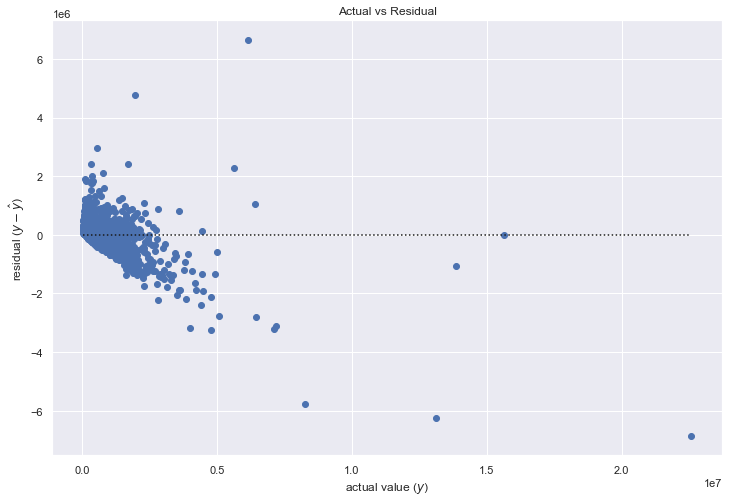

In [336]:
evaluate.plot_residuals(y_pred.actual, y_pred[0], y_pred)

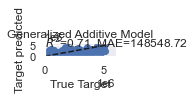

In [337]:
f, (ax1) = plt.subplots(1, 1)


ax1.scatter(y_test, y_pred[0])
ax1.plot([0, 6000000], [0, 6000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Generalized Additive Model')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred[0]), median_absolute_error(y_test, y_pred[0])))
ax1.set_xlim([0, 6000000])
ax1.set_ylim([0, 6000000])

f.tight_layout(rect=[0.8, 0.8, 0.95, 0.95])

plt.show()

In [338]:
y_pred.apply(lambda col: median_absolute_error(y_pred.actual, col))

0          148548.722
actual          0.000
residual   372013.001
dtype: float64

In [339]:
y_pred.apply(lambda col: r2_score(y_pred.actual, col))

0           0.714
actual      1.000
residual   -0.201
dtype: float64

# GAM Summary with test data
# Median Absolute Error: 145,548
# R2 value: 0.714

In [252]:

# i=2
# XX = gam.generate_X_grid(term=i)
# XX[:, i]
# #ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))

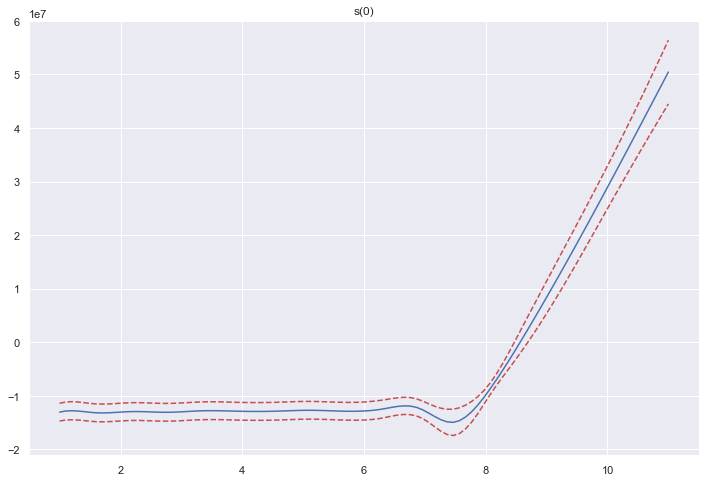

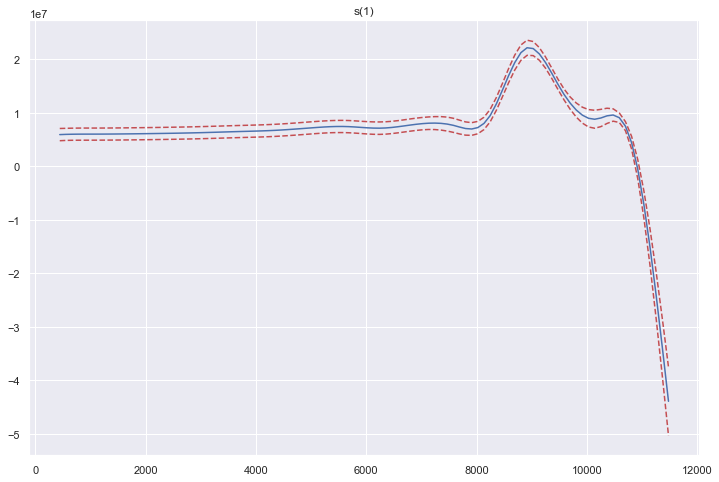

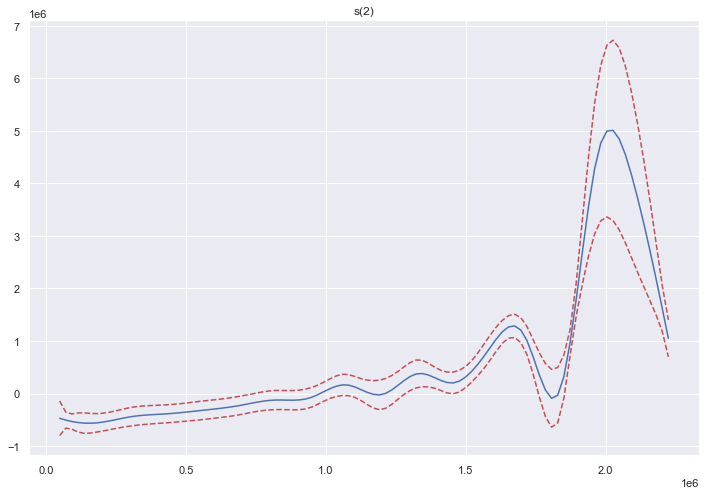

In [340]:
# Lets plot partial dependence plots for each variable
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

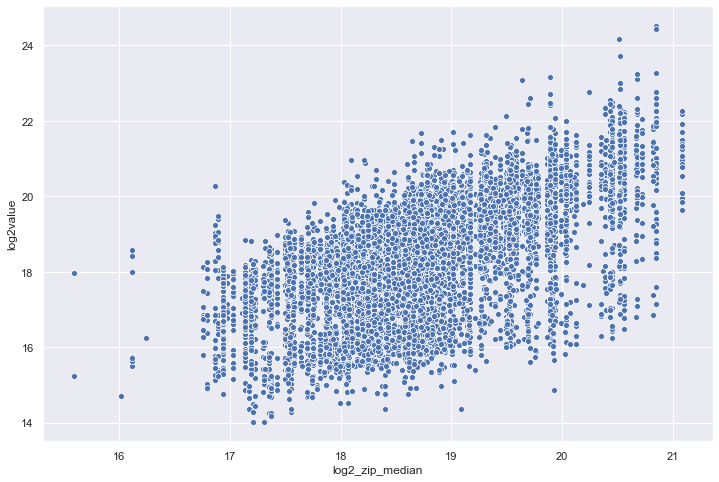

In [215]:
sns.scatterplot(x='log2_zip_median', y = 'log2value', data=train)

# Lets try a polynomial linear model with X_train = train[['bathrooms', 'log2sf', 'latitude', 'longitude', 'log2_zip_median']]

In [341]:
X_train = train[['bathrooms', 'log2sf', 'latitude', 'longitude', 'log2_zip_median']]
y_train = train[['log2value']]
X_test = test[[ 'bathrooms', 'log2sf','latitude', 'longitude', 'log2_zip_median']]
y_test = test[['assessed_value']]

In [342]:
# X_train = train[['bathrooms', 'log2sf', 'log2_zip_median','latitude', 'longitude']]
# y_train = train[['assessed_value']]
# X_test = test[[ 'bathrooms', 'log2sf','log2_zip_median','latitude', 'longitude']]
# y_test = test[['assessed_value']]

In [343]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [344]:
X_poly = pd.DataFrame(poly.transform(X_train), columns=poly.get_feature_names(X_train.columns))
X_poly.head(2)

,1,bathrooms,log2sf,latitude,longitude,log2_zip_median,bathrooms^2,bathrooms log2sf,bathrooms latitude,bathrooms longitude,...,log2sf^2,log2sf latitude,log2sf longitude,log2sf log2_zip_median,latitude^2,latitude longitude,latitude log2_zip_median,longitude^2,longitude log2_zip_median,log2_zip_median^2
0,1.000,3.000,11.057,34663693.000,-118185301.000,17.865,9.000,33.170,103991079.000,-354555903.000,...,122.249,383263895.369,-1306732056.409,197.525,1201571612398249.000,-4096738990976593.000,619262343.527,13967765372460600.000,-2111364950.863,319.154
1,1.000,2.000,10.736,34178821.000,-118607295.000,19.117,4.000,21.471,68357642.000,-237214590.000,...,115.252,366928647.677,-1273315260.317,205.235,1168191804950041.000,-4053857505099195.000,653408358.231,14067690427217024.000,-2267456735.859,365.473


In [345]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['log_predicted_poly'] = lm_poly.predict(X_poly)

In [346]:
y_train.head()

,log2value,log_predicted_poly
11938,18.035,17.828
790,16.548,18.604
3846,18.308,18.735
14846,18.931,18.923
1469,18.982,18.088


In [347]:
y_train['actual'] = 2**y_train.log2value
y_train['poly_predicted'] = 2**y_train.log_predicted_poly
#y_train['median_bl'] =  train['log2value'].median()

In [348]:
y_train.head(2)

,log2value,log_predicted_poly,actual,poly_predicted
11938,18.035,17.828,268557.000,232759.637
790,16.548,18.604,95849.000,398376.681


In [349]:
y_train.apply(lambda col: median_absolute_error(y_train.actual, col))

log2value            389591.428
log_predicted_poly   389591.732
actual                    0.000
poly_predicted       151660.584
dtype: float64

In [350]:
y_train.apply(lambda col: r2_score(y_train.actual, col))

log2value            -0.573
log_predicted_poly   -0.573
actual                1.000
poly_predicted        0.463
dtype: float64

# Polynomial Linear  Regression Summary:
# Median Absolute Error: 151,660
# R2 value: 0.463

-----------------------------------------------------

# Lets try Ridge Regressions with cross-validation

In [351]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [352]:
X_train = train[[ 'log2sf','log2_zip_median']]
y_train = train[['log2value']]
X_test = test[['log2sf','log2_zip_median']]
y_test = test[['log2value']]

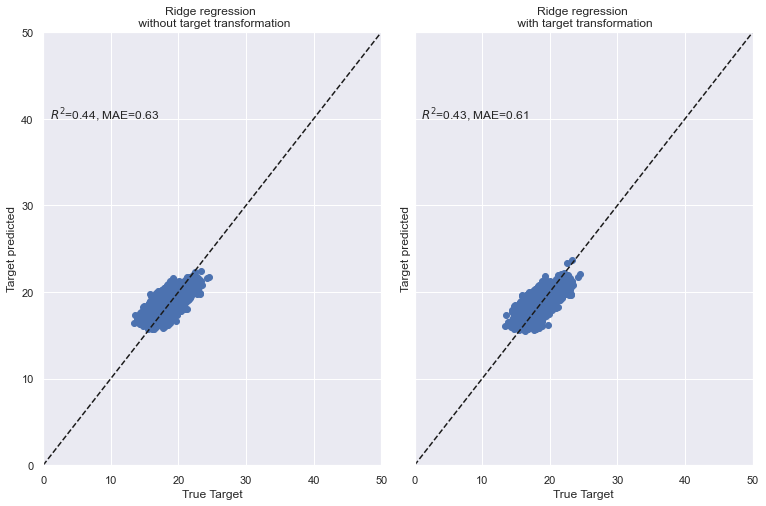

In [353]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)

ax0.scatter(y_train, y_pred)
ax0.plot([0, 50], [0, 50], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 40, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train, y_pred), median_absolute_error(y_train, y_pred)))
ax0.set_xlim([0, 50])
ax0.set_ylim([0, 50])

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_train)

ax1.scatter(y_train, y_pred)
ax1.plot([0, 50], [0, 50], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 40, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train, y_pred), median_absolute_error(y_train, y_pred)))
ax1.set_xlim([0, 50])
ax1.set_ylim([0, 50])

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

In [354]:
y_pred = pd.DataFrame(y_pred, columns = ['predicted_log'],index=y_train.index)

In [355]:
y_pred.head(2)

,predicted_log
11938,18.232
790,18.796


In [356]:
y_pred1 = train[['assessed_value']]

In [357]:
y_pred1.head(2)

,assessed_value
11938,268557.000
790,95849.000


In [358]:
df1 = pd.concat([y_pred, y_pred1], axis=1)

In [359]:
df1.head(2)

,predicted_log,assessed_value
11938,18.232,268557.000
790,18.796,95849.000


In [360]:
df1['predicted1'] = 2**df1.predicted_log

In [361]:
df1.head(2)

,predicted_log,assessed_value,predicted1
11938,18.232,268557.000,307789.244
790,18.796,95849.000,455261.012


In [362]:
df1.apply(lambda col: median_absolute_error(df1.assessed_value, col))

predicted_log    389591.474
assessed_value        0.000
predicted1       152901.407
dtype: float64

In [363]:
df1.apply(lambda col: r2_score(df1.assessed_value, col))

predicted_log    -0.573
assessed_value    1.000
predicted1        0.419
dtype: float64

# Ridge Regression Summary:
# Median Absolute Error: 152,901
# R2 value: 0.419

----------------------------------------

# Lets now try to remove outliers and then do modeling

In [364]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,...,tax_value,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age,zip_median,log2_zip_median
0,2.000,3.000,1458.000,6037,8284,1,97318,1970,34686163.000,-118113100.000,...,2319.900,2017-06-23,0.017,Los Angles,10.510,13.016,17.054,30,144172.000,17.137
1,1.000,2.000,1421.000,6037,6707,0,96018,1911,33999877.000,-118291863.000,...,543.690,2017-06-30,0.015,Los Angles,10.473,12.711,15.120,89,162337.000,17.309


In [365]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [366]:
train = train[train.assessed_value< 1000000]

In [367]:
#train_plot = train[['bathrooms', 'bedrooms', 'square_feet', 'assessed_value', 'lot_size']]

In [368]:
#explore.plot_variable_pairs(train_plot)

In [369]:
#bath_cutoff = train.bathrooms.mean() + 3*train.bathrooms.std()

In [370]:
#bed_cutoff = train.bedrooms.mean() + 3*train.bedrooms.std()

In [371]:
#sf_cutoff = train.square_feet.mean() + 3*train.square_feet.std()

In [372]:
#bath_cutoff, bed_cutoff , sf_cutoff

In [373]:
#train = train[train.bathrooms<bath_cutoff][train.bedrooms<bed_cutoff][train.square_feet<sf_cutoff]

In [374]:
#train.assessed_value.max()

In [375]:
#outliers = train[train.assessed_value>1000000]

In [376]:
#outliers.info()

In [377]:
#outliers_plot = outliers[['bathrooms', 'bedrooms', 'square_feet', 'assessed_value', 'lot_size']]

In [378]:
#explore.plot_variable_pairs(outliers_plot)

In [379]:
X_train = train[['bedrooms', 'bathrooms', 'log2sf']]
y_train = train[['log2value']]
X_test = test[['bedrooms', 'bathrooms', 'log2sf']]
y_test = test[['log2value']]

In [380]:
predictions = pd.DataFrame({
    'actual_log': y_train.log2value
})
predictions.head(2)

,actual_log
11938,18.035
790,16.548


In [381]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('log2value ~ bedrooms + bathrooms + log2sf', data = train).fit()

# compute predictions and add to original dataframe
predictions['ols_log'] = ols_model.predict(X_train)

In [382]:
predictions['actual'] = 2**predictions.actual_log
predictions['ols_predicted'] = 2**predictions.ols_log

In [383]:
(2**y_train.log2value).mean()

377045.96587841486

In [384]:
predictions.head()

,actual_log,ols_log,actual,ols_predicted
11938,18.035,18.664,268557.000,415383.095
790,16.548,18.035,95849.000,268547.775
3846,18.308,18.380,324613.000,341233.328
14846,18.931,18.785,499860.000,451642.276
1469,18.982,17.947,517777.000,252628.507


In [385]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: median_absolute_error(predictions.actual, col))

actual_log      344368.606
ols_log         344368.530
actual               0.000
ols_predicted   156431.636
dtype: float64

In [386]:
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

actual_log      446394.657
ols_log         446395.111
actual               0.000
ols_predicted   223132.376
dtype: float64

In [387]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log2value   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     672.6
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:52:22   Log-Likelihood:                -13684.
No. Observations:                9261   AIC:                         2.738e+04
Df Residuals:                    9257   BIC:                         2.740e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0172      0.337     29.725      0.000       9.357      10.678
bedrooms      -0.1616      0.017     -9.469      0.000      -0.195      -0.128
bathrooms      0.2218      0.024      9.389      0.000       0.176       0.268
log2sf         0.7657      0.036     21.006      0.000       0.694       0.837
==============================================================================
Omnibus:                      629.231   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              731.158
Skew:                          -0.671   Prob(JB):                    1.70e-159
Kurtosis:                       2.697   Cond. No.                         352.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [388]:
predictions2 = pd.DataFrame({
    'actual_log': y_test.log2value
})
predictions2.head(2)

,actual_log
9116,20.367
2397,19.605


In [389]:
predictions2['test_ols_log'] = ols_model.predict(X_test)

In [390]:
predictions2['actual'] = 2**predictions2.actual_log
predictions2['test_ols_predicted'] = 2**predictions2.test_ols_log

In [391]:
predictions2.head(2)

,actual_log,test_ols_log,actual,test_ols_predicted
9116,20.367,18.978,1352462.000,516348.014
2397,19.605,18.839,797339.000,468927.282


In [392]:
predictions2.apply(lambda col: median_absolute_error(predictions2.actual, col))

actual_log           371192.998
test_ols_log         371193.006
actual                    0.000
test_ols_predicted   171045.651
dtype: float64

# It is wierd that removing outliers led to higher Median Absolute Error(MAE) on OLS model. However, the MAE is better on test model. 